In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import zscore

DATA_PATH = "../data/daily/us"
SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'UNH']

def load_data(symbol, base_path=DATA_PATH):
    search_patterns = [
        os.path.join(base_path, "**", f"{symbol.lower()}.us.txt"),
        os.path.join(base_path, "nyse stocks", "**", f"{symbol.lower()}.us.txt"),
        os.path.join(base_path, "nasdaq stocks", "**", f"{symbol.lower()}.us.txt"),
    ]
    
    files = []
    for pattern in search_patterns:
        files = glob.glob(pattern, recursive=True)
        if files:
            break
    
    if not files:
        return None
    
    try:
        df = pd.read_csv(files[0])
        df.columns = [c.replace('<', '').replace('>', '').capitalize() for c in df.columns]
        
        if 'Vol' in df.columns:
            df.rename(columns={'Vol': 'Volume'}, inplace=True)
        
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
            df.set_index('Date', inplace=True)
        elif 'Time' in df.columns:
            df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d')
            df.set_index('Time', inplace=True)
            df.index.name = 'Date'
        
        if 'Volume' not in df.columns:
            df['Volume'] = 0
            
        return df.dropna(subset=['Open', 'High', 'Low', 'Close'])
        
    except:
        return None

In [38]:
def form_quintile_portfolios(df, signal_col, ret_col='next_ret', q=5, min_n=None):
    """
    Forms q-quantile portfolios each date with monthly rebalancing.
    Returns equal-weighted returns for each quintile.
    """
    df = df.copy()
    if min_n is None:
        min_n = q  
    
    def assign_bucket(x):
        x = x.dropna()
        if len(x) < min_n:
            return pd.Series(index=x.index, data=np.nan)
        pr = x.rank(method='first', pct=True)
        try:
            return pd.qcut(pr, q, labels=False, duplicates='drop') + 1
        except ValueError:
            return pd.Series(index=x.index, data=np.nan)
    
    # Groups by date and assigns quintiles
    df['quintile'] = df.groupby(level=0)[signal_col].transform(assign_bucket)
    df = df.dropna(subset=['quintile', ret_col])
    df['quintile'] = df['quintile'].astype(int)
    
    # Equal-weight returns per quintile per month
    out = df.groupby([df.index, 'quintile'])[ret_col].mean().unstack()
    
    # Ensure all quintiles exist
    for k in range(1, q+1):
        if k not in out.columns:
            out[k] = np.nan
    
    return out[sorted(out.columns)]

In [39]:
def calculate_performance_metrics(returns_series):
    """
    Calculate annualized performance metrics
    """
    returns_series = returns_series.dropna()
    
    if len(returns_series) == 0:
        return {
            'Ann. Return': np.nan,
            'Ann. Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    
    ann_ret = returns_series.mean() * 12
    ann_vol = returns_series.std() * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else 0
    
    # Drawdown 
    cum_rets = (1 + returns_series).cumprod()
    running_max = cum_rets.cummax()
    drawdown = (cum_rets / running_max) - 1
    max_dd = drawdown.min()
    
    return {
        'Ann. Return': ann_ret,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

In [40]:
def run_week2_tasks():
    stock_dict = {}
    
    # Load stock data
    for s in SYMBOLS:
        df = load_data(s)
        if df is not None:
            # Resample to monthly
            monthly = df.resample('ME').last()
            
            # Calculate next month's return
            monthly['next_ret'] = monthly['Close'].pct_change().shift(-1)
            
            # 12-1 month momentum (skipping most recent month)
            monthly['momentum_12_1'] = (monthly['Close'].shift(1) / monthly['Close'].shift(12)) - 1
            
            # Value (using contrarian approach), negative of 12-month return
            monthly['value_score'] = -(monthly['Close'] / monthly['Close'].shift(12) - 1)
            
            monthly['Symbol'] = s
            stock_dict[s] = monthly
    
    # Cross-sectional panel
    panel = pd.concat(stock_dict.values()).sort_index()
    
    # Remove rows with missing signals or returns
    panel = panel.dropna(subset=['momentum_12_1', 'value_score', 'next_ret'])
    
    # Filter to dates where all stocks have data 
    date_counts = panel.groupby(panel.index).size()
    full_coverage_dates = date_counts[date_counts == len(SYMBOLS)].index
    panel = panel[panel.index.isin(full_coverage_dates)]
    
    print(f"Analysis period: {panel.index.min().date()} to {panel.index.max().date()}")
    print(f"Months with full coverage: {len(full_coverage_dates)}")
    
    # Value scores and rankings
    print("\nValue Scores and Rankings:")
    
    panel['value_rank'] = panel.groupby(panel.index)['value_score'].rank(ascending=False)
    sample_date = panel.index.unique()[-1]
    print(f"\nDate: {sample_date.date()}")
    print(panel.loc[sample_date, ['Symbol', 'value_score', 'value_rank']].sort_values('value_rank'))

    # Momentum factors
    print("\nMomentum Factors")
    
    print(f"\nManually check for AAPL:")
    aapl_data = stock_dict['AAPL'][['Close', 'momentum_12_1']].tail(3)
    print(aapl_data)
    
    # Plot momentum distribution
    test_date = panel.index.unique()[-5]
    plt.figure(figsize=(10, 6))
    mom_scores = panel.loc[test_date, 'momentum_12_1']
    plt.hist(mom_scores, bins=10, edgecolor='white', alpha=0.7)
    plt.title(f"Momentum Score Distribution on {test_date.date()}")
    plt.xlabel("12-1m Momentum")
    plt.ylabel("Frequency")
    plt.axvline(mom_scores.median(), color='red', linestyle='--', label=f'Median: {mom_scores.median():.2f}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Quintile portfolio
    print("\nQuintile Portfolios (Monthly Rebalancing)")
    
    mom_quintiles = form_quintile_portfolios(panel, 'momentum_12_1', q=5)
    val_quintiles = form_quintile_portfolios(panel, 'value_score', q=5)
    
    print(f"\nMomentum quintiles: {len(mom_quintiles)} months")
    print(f"Value quintiles: {len(val_quintiles)} months")
    
    # Cumulative returns for each quintile
    print("\nCumulative Returns by Quintile")
    
    # Momentum Quintiles
    plt.figure(figsize=(12, 6))
    mom_cum = (1 + mom_quintiles).cumprod()
    for q in [1, 2, 3, 4, 5]:
        if q in mom_cum.columns:
            plt.plot(mom_cum[q], label=str(q), linewidth=2 if q in [1, 5] else 1)
    plt.title("Momentum Quintile Performance", fontsize=14)
    plt.ylabel("Growth of $1", fontsize=11)
    plt.legend(title="Quintile", loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nMomentum Quintile Statistics:\n")
    print(mom_quintiles.describe())
    
    # Long short spread
    print("\nLong-Short Spread Performance")
    
    mom_ls = mom_quintiles[5] - mom_quintiles[1]  
    val_ls = val_quintiles[5] - val_quintiles[1]  
    
    plt.figure(figsize=(12, 6))
    (1 + mom_ls).cumprod().plot(label='Momentum L-S (Q5-Q1)', linewidth=2, color='blue')
    (1 + val_ls).cumprod().plot(label='Value L-S (Q5-Q1)', linewidth=2, color='orange')
    plt.title("Long-Short Portfolio Cumulative Returns", fontsize=14)
    plt.ylabel("Growth of $1", fontsize=11)
    plt.xlabel("Date", fontsize=11)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary table of quintile portfolio statistics
    print("\nSummary Table of Statistics\n")
    
    metrics = {
        'Momentum L-S': calculate_performance_metrics(mom_ls),
        'Value L-S': calculate_performance_metrics(val_ls)
    }
    
    summary_df = pd.DataFrame(metrics).T
    print(summary_df)
    
    # Year by year factor returns
    print("\nYear-by-Year Factor Returns")
    
    # Annual returns (geometric)
    mom_yearly = mom_ls.resample('YE').apply(lambda x: (1 + x).prod() - 1)
    val_yearly = val_ls.resample('YE').apply(lambda x: (1 + x).prod() - 1)
    
    # Plot year-by-year
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(mom_yearly))
    width = 0.35
    
    ax.bar(x - width/2, mom_yearly, width, label='Momentum', alpha=0.7, color='blue')
    ax.bar(x + width/2, val_yearly, width, label='Value', alpha=0.7, color='orange')
    
    ax.set_xlabel('Year', fontsize=11)
    ax.set_ylabel('Annual Return', fontsize=11)
    ax.set_title('Year-by-Year Factor Returns', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([d.year for d in mom_yearly.index], rotation=45)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation
    corr = mom_ls.corr(val_ls)
    print(f"\nCorrelation between Momentum and Value L-S: {corr:.4f}")
    
    if corr < -0.5:
        print("Strong negative correlation - Momentum and Value are contrarian strategies")
    elif corr > 0.5:
        print("Strong positive correlation - Momentum and Value move together")
    else:
        print("Weak correlation - Momentum and Value are relatively independent")

Analysis period: 2013-05-31 to 2025-12-31
Months with full coverage: 152

Value Scores and Rankings:

Date: 2025-12-31
           Symbol  value_score  value_rank
Date                                      
2025-12-31    UNH     0.339986         1.0
2025-12-31   AMZN    -0.052099         2.0
2025-12-31   AAPL    -0.090528         3.0
2025-12-31      V    -0.111569         4.0
2025-12-31   TSLA    -0.113609         5.0
2025-12-31   META    -0.127376         6.0
2025-12-31   MSFT    -0.147378         7.0
2025-12-31    JPM    -0.344208         8.0
2025-12-31   NVDA    -0.388785         9.0
2025-12-31  GOOGL    -0.653460        10.0

Momentum Factors

Manually check for AAPL:
              Close  momentum_12_1
Date                              
2025-11-30  278.850       0.143256
2025-12-31  271.860       0.118568
2026-01-31  258.175       0.157161


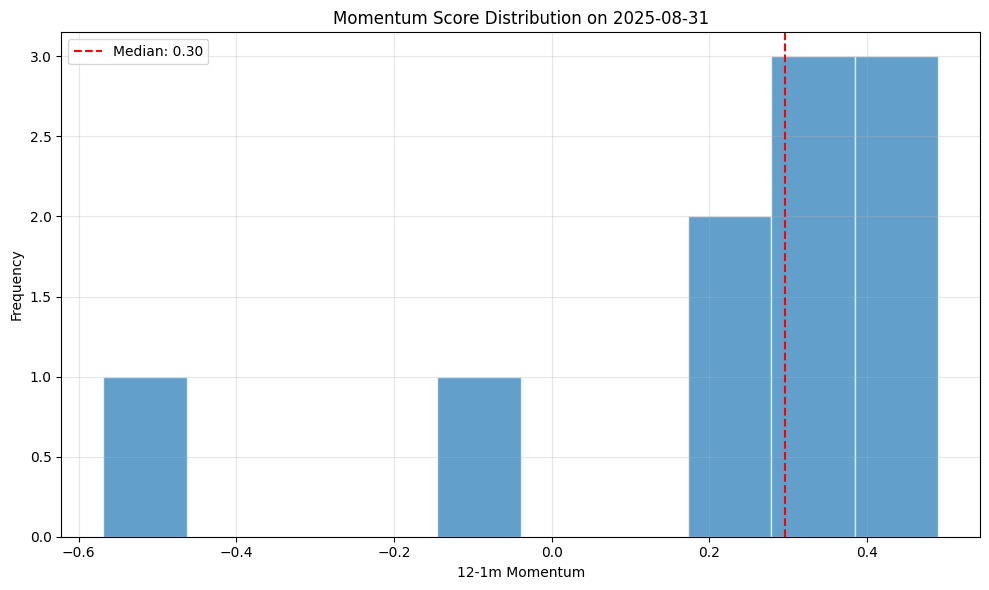


Quintile Portfolios (Monthly Rebalancing)

Momentum quintiles: 152 months
Value quintiles: 152 months

Cumulative Returns by Quintile


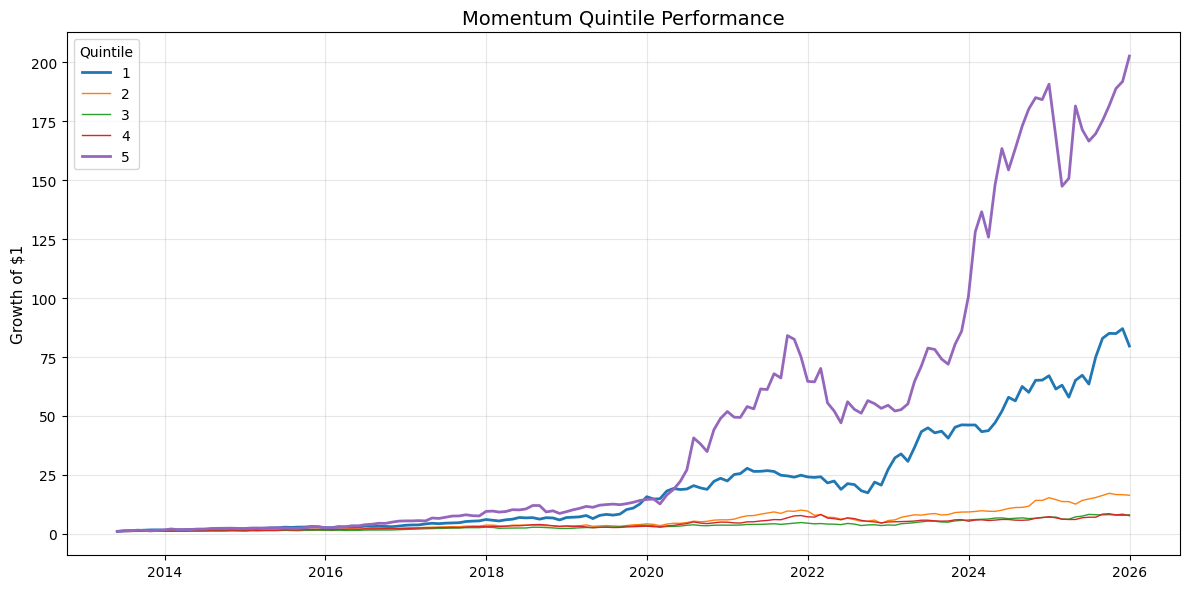


Momentum Quintile Statistics:

quintile           1           2           3           4           5
count     152.000000  152.000000  152.000000  152.000000  152.000000
mean        0.032776    0.021042    0.015336    0.015561    0.040408
std         0.087096    0.070823    0.055098    0.065161    0.102210
min        -0.168853   -0.248614   -0.169059   -0.185706   -0.225967
25%        -0.030130   -0.014367   -0.013842   -0.023865   -0.019120
50%         0.023708    0.024577    0.018743    0.015840    0.027253
75%         0.082450    0.056126    0.053430    0.059022    0.089275
max         0.322072    0.282306    0.176265    0.189248    0.500765

Long-Short Spread Performance


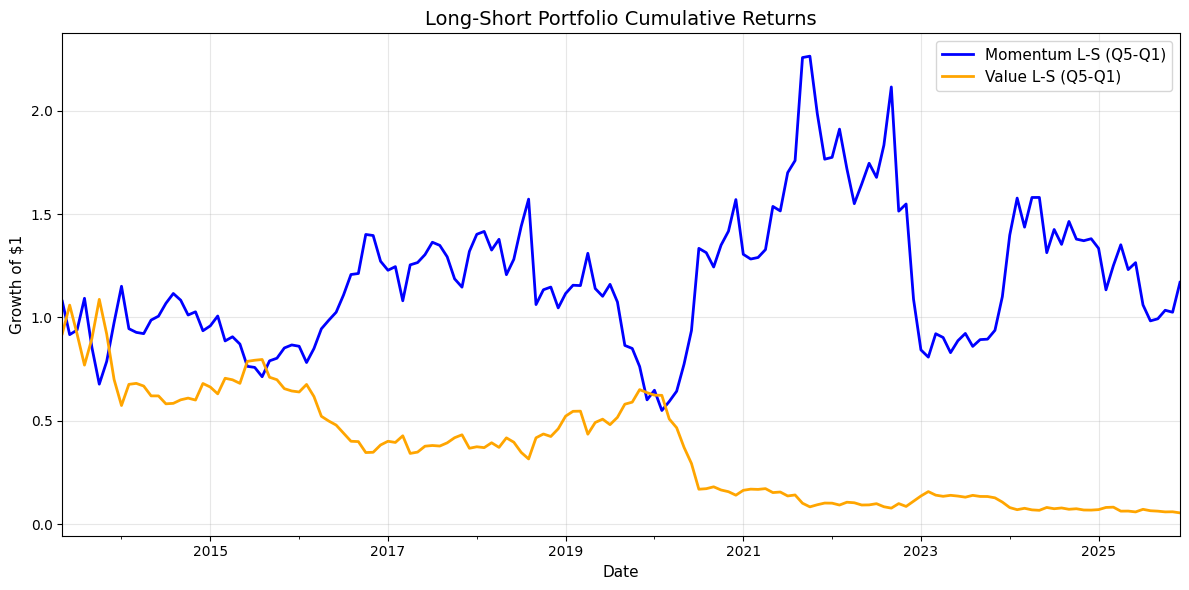


Summary Table of Statistics

              Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
Momentum L-S     0.091580         0.395630      0.231480     -0.650443
Value L-S       -0.144797         0.401758     -0.360408     -0.950174

Year-by-Year Factor Returns


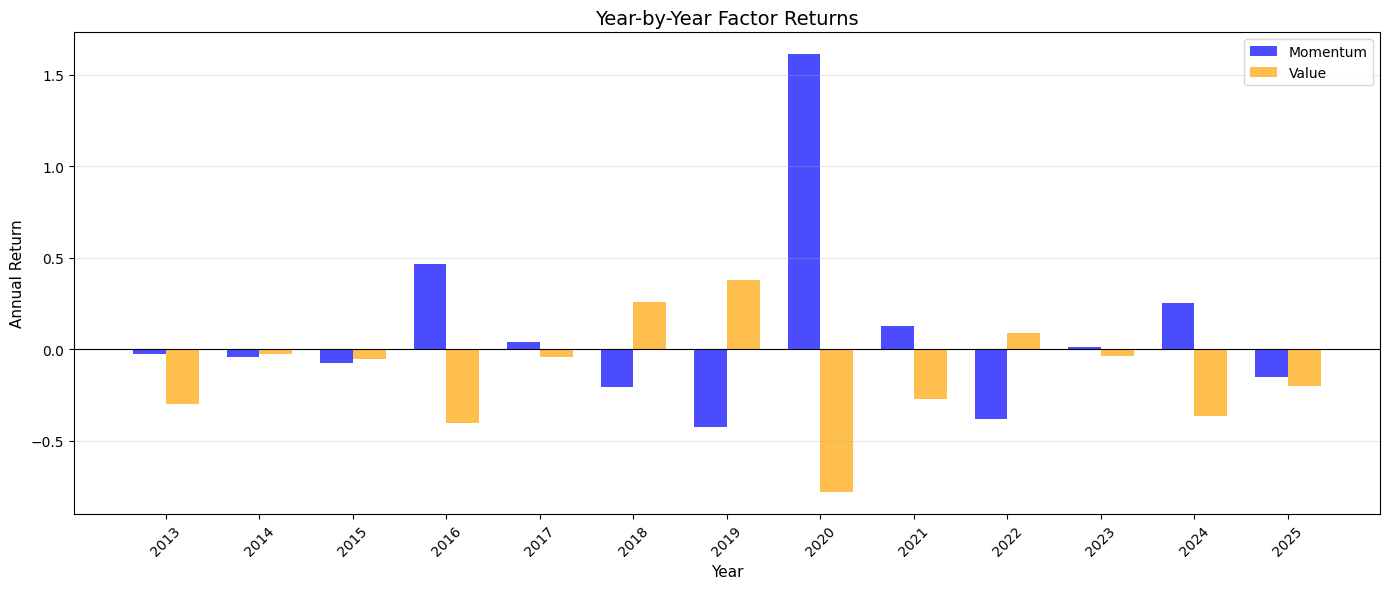


Correlation between Momentum and Value L-S: -0.8945
Strong negative correlation - Momentum and Value are contrarian strategies


In [41]:
if __name__ == "__main__":
    run_week2_tasks()